In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime
import math
import QuantLib as ql
from scipy.optimize import minimize

from initialize import *
from plots import *
from SABR import *
from Heston import *
from mixedSABR import *
data, strikes, len(strikes), dates, len(dates),len(strikes)*len(dates)


('OIL',
 array([41., 45., 47., 48., 50., 52., 54., 55., 60., 62., 64., 66., 70.,
        72., 75., 80.]),
 16,
 [Date(15,10,2021),
  Date(16,11,2021),
  Date(15,12,2021),
  Date(14,1,2022),
  Date(16,2,2022),
  Date(17,3,2022),
  Date(14,4,2022),
  Date(17,5,2022)],
 8,
 128)

Tenors  Spot Rate
0    0.25     -0.575
1    1.00     -0.557
2    3.00     -0.549
3    6.00     -0.529
4   12.00     -0.494

Text(0.5, 1.0, 'EONIA Rates (%) 1996-2021')

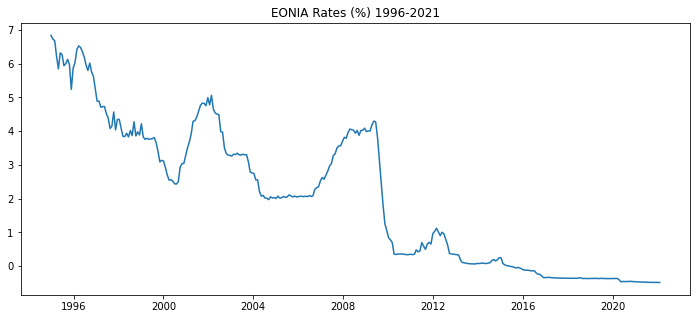

In [2]:
# Spot rates table and chart (EONIA)

rates = [-0.575, -0.557, -0.549, -0.529, -0.494]
tenors = [.25, 1, 3, 6, 12]

spot_rates = pd.DataFrame({"Tenors": tenors, "Spot Rate": rates})
spot_rates.set_index('Tenors')

display(spot_rates)

fig = plt.figure(figsize=(12,5))
eonia_dates = [datetime.date(1994, 12, 31) + datetime.timedelta(days=30*n) for n in range(len(eonia_rates['value']))]
plt.plot(eonia_dates, eonia_rates['value'])
plt.title("EONIA Rates (%) 1996-2021")

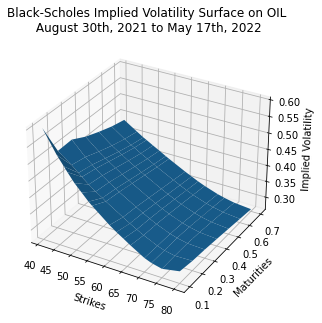

In [3]:
# BLACK VOLATILITY SURFACE

title = "Black-Scholes Implied Volatility Surface on {}\n {} to {}".format(data, today, dates[-1])
plot_vol_surface(vol_surface=black_var_surface, plot_strikes=strikes, funct='blackVol', title=title)

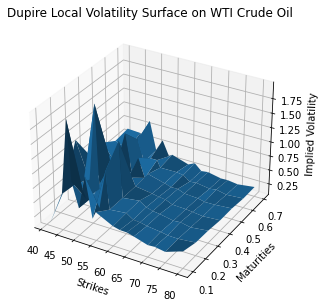

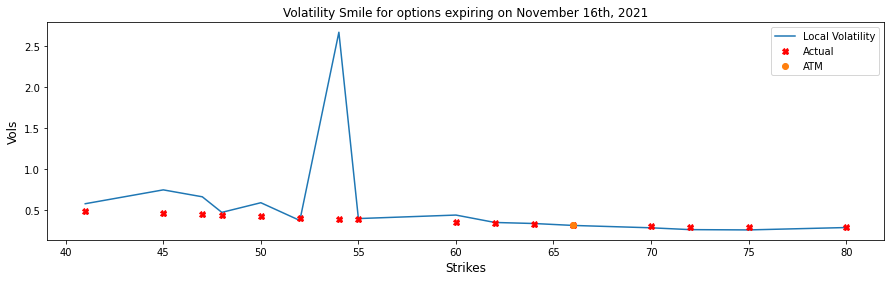

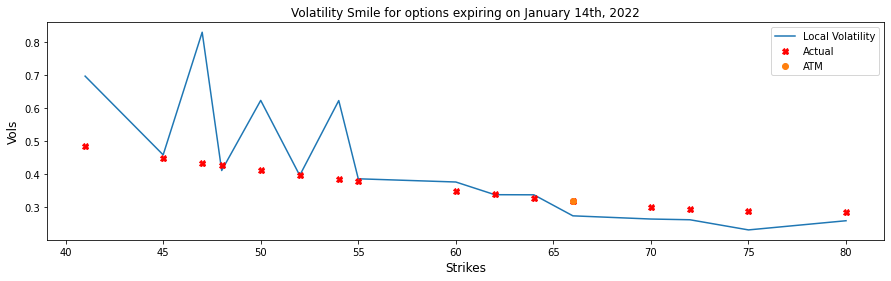

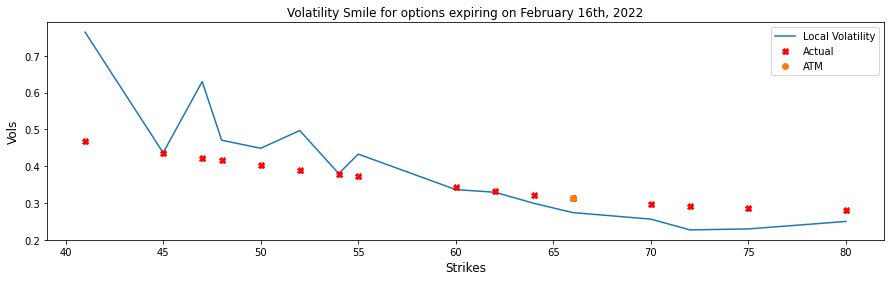

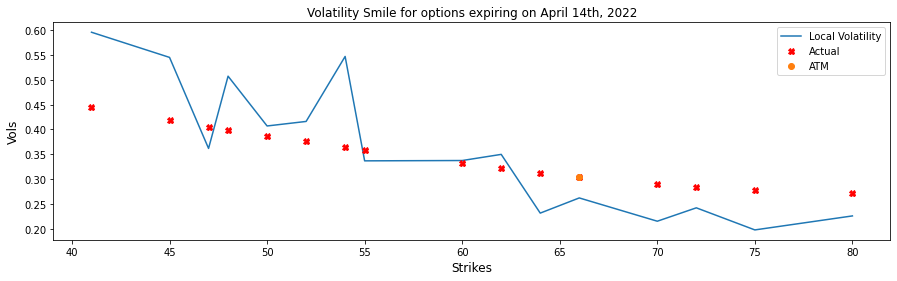

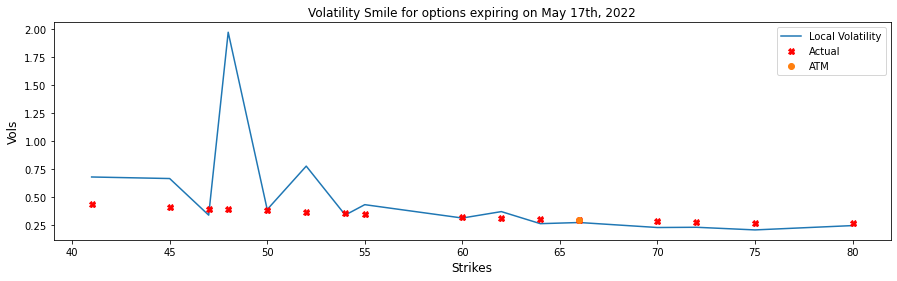

In [17]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

black_var_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)

# local_vol_surface = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)
local_vol_surface = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, .1)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, funct='localVol', title="Dupire Local Volatility Surface on {}".format(data_label))

smiles_comparison(local_models=[local_vol_surface], black_volatility=False)

In [5]:
#HESTON MODEL SURFACE PLOTTING (Levenberg-Marquardt Method)

m1_params, m2_params = (None, None)

if data == "SPX":
    m1_params = (0.05,0.2,0.5,0.1,0.09)
    m2_params = (0.15,0.5,0.2,0.7,0.01)
elif data == "COFFEE":
    m1_params = (0.01,0.1,0.3,0.1,0.02)
    m2_params = (0.2,0.9,0.9,0.9,-0.19)
elif data == "OIL":
    m2_params = (0.023,0.009,1.00,0.95,0.2)
    m1_params = (0.15,0.5,0.2,0.7,0.01)
elif data == "GOLD":
    m1_params = (0.03,0.3,0.5,0.3,0.04)
    m2_params = (0.01,0.5,0.5,0.1,0.03)
else:
    m1_params = (0.03,0.3,0.5,0.3,0.04)
    m2_params = (0.01,0.5,0.5,0.1,0.03)

hestonModel1 = hestonModelSurface(m1_params, label="Heston Model 1, {}".format(data_label))
hestonModel2 = hestonModelSurface(m2_params, label="Heston Model 2, {}".format(data_label))

# Use to Calibrate first time the Heston Model
def calibrateHeston():
    def f(params):
        return hestonModelSurface(params).avgError
        # v0, kappa, theta, sigma, rho
    cons = (
            {'type': 'ineq', 'fun': lambda x: x[0] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[0]},
            {'type': 'ineq', 'fun': lambda x: x[1] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[1]},
            {'type': 'ineq', 'fun': lambda x: x[2] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[2]},
            {'type': 'ineq', 'fun': lambda x: x[3] - 0.001},
            {'type': 'ineq', 'fun': lambda x: .999 - x[3]},
            {'type': 'ineq', 'fun': lambda x: .99 - x[4]**2}
            ) 
    result = minimize(f, m1_params, constraints=cons, method="SLSQP", bounds=((1e-8, None), (1e-8, None), (1e-8, None), (-.999, .999), (-.999, .999)))
    hestonModel0 = hestonModelSurface(result["x"], label="Heston Model 0, {}".format(data_label))


    plot_vol_surface(hestonModel0.heston_vol_surface, title="{} Volatility Surface".format(hestonModel0.label))
    plot_vol_surface(hestonModel1.heston_vol_surface, title="{} Volatility Surface".format(hestonModel1.label))

init_conditions = pd.DataFrame({"theta": [m1_params[0], m2_params[0]], "kappa": [m1_params[1], m2_params[1]], 
                                "sigma": [m1_params[2], m2_params[2]], "rho": [m1_params[3], m2_params[3]], 
                                "v0": [m1_params[4], m2_params[4]]}, index = ["Model1","Model2"])
display(init_conditions.style.set_caption("Heston Model Initial Conditions on ({})".format(data_label)))

No handles with labels found to put in legend.


No handles with labels found to put in legend.


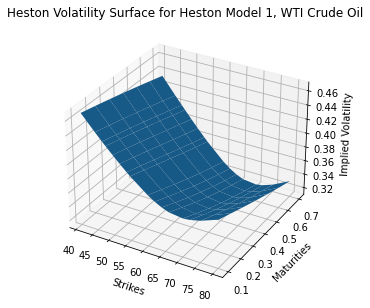

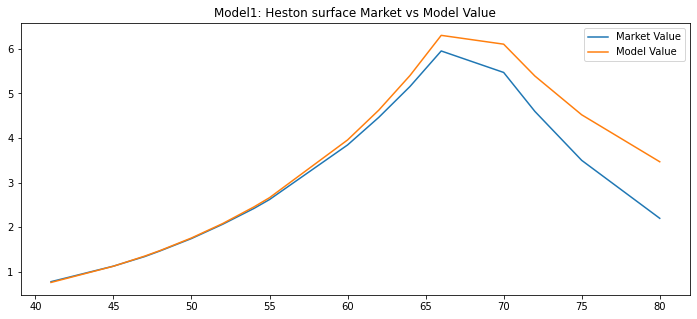

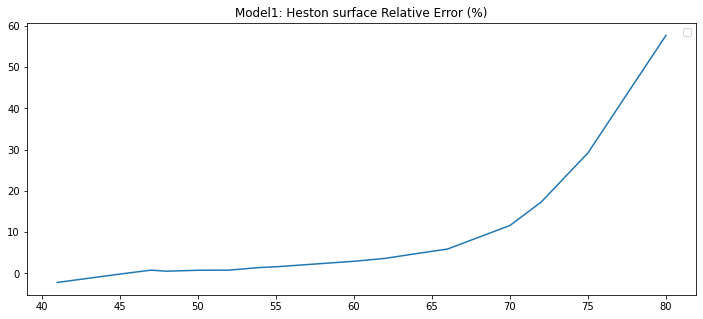

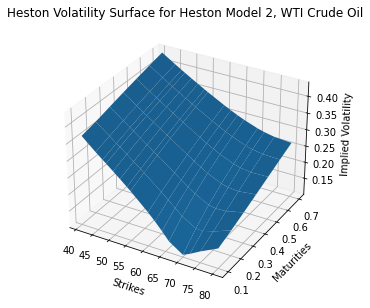

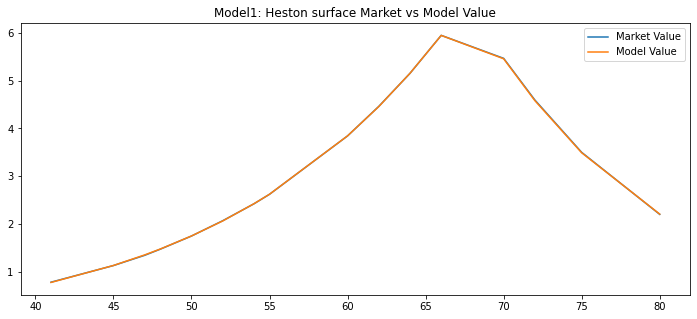

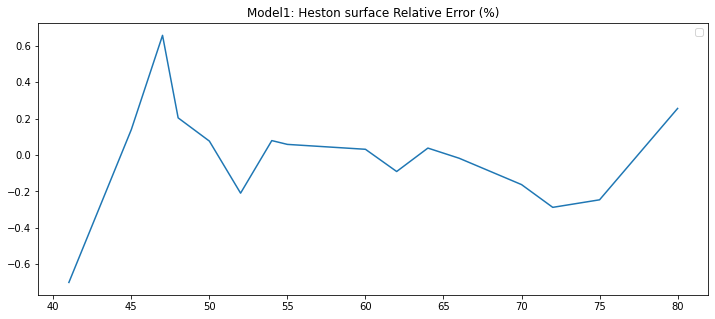

In [6]:
# HESTON Surface Plotting (Model1, Model2)

for model in (hestonModel1, hestonModel2):
    plot_vol_surface(model.heston_vol_surface, title="Heston Volatility Surface for {}".format(model.label))
    display(model.errors_data.style.set_caption("{} calibration results".format(model.label))); display(model.var_data.style.set_caption("{} parameters output".format(model.label)))

    fig1 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.marketValue, label="Market Value")
    plt.plot(model.strks, model.modelValue, label="Model Value")
    plt.title('Model1: Heston surface Market vs Model Value'); plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()
    fig2 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.relativeError)
    plt.title('Model1: Heston surface Relative Error (%)'); plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()

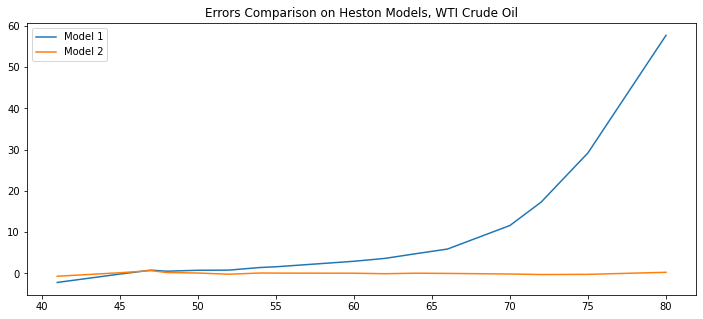

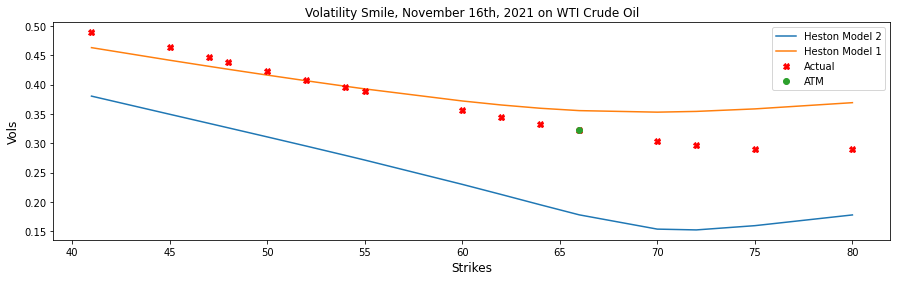

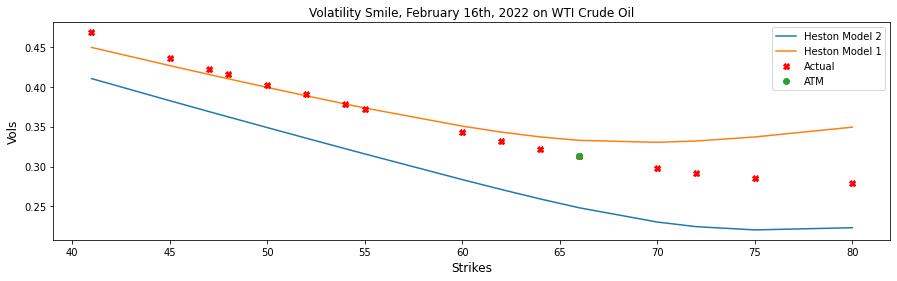

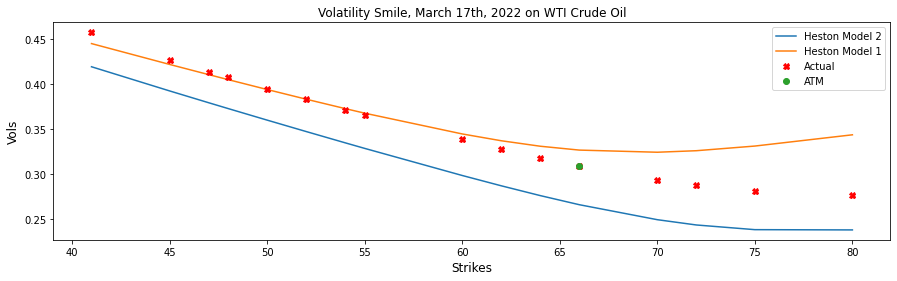

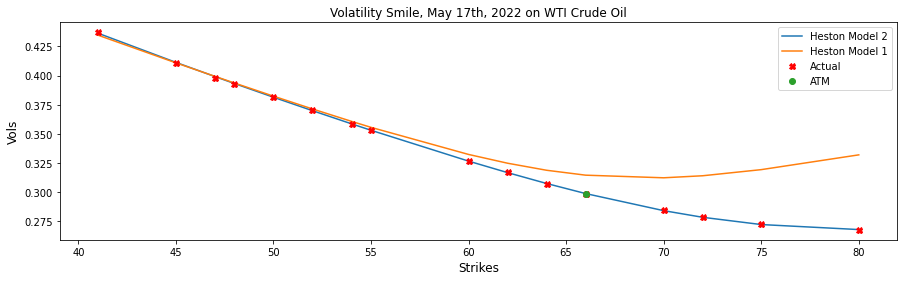

In [7]:
# Relative error comparison
plt.figure(figsize=plot_size)
plt.plot(hestonModel1.strks, hestonModel1.relativeError, label="Model 1")
plt.plot(hestonModel2.strks, hestonModel2.relativeError, label="Model 2")
plt.title("Errors Comparison on Heston Models, {}".format(data_label));
plt.legend()

# Volatility smiles comparison
tenors = [dates[round((len(dates)-1) * x)] for x in (.2, .5, .75, 1)]
for tenor in tenors:
    l = [
        ([hestonModel2.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 2" ),
        ([hestonModel1.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 1" )
        ]
    plot_smile(tenor, l, market=True)

NameError: name 'plot_vol_surface' is not defined

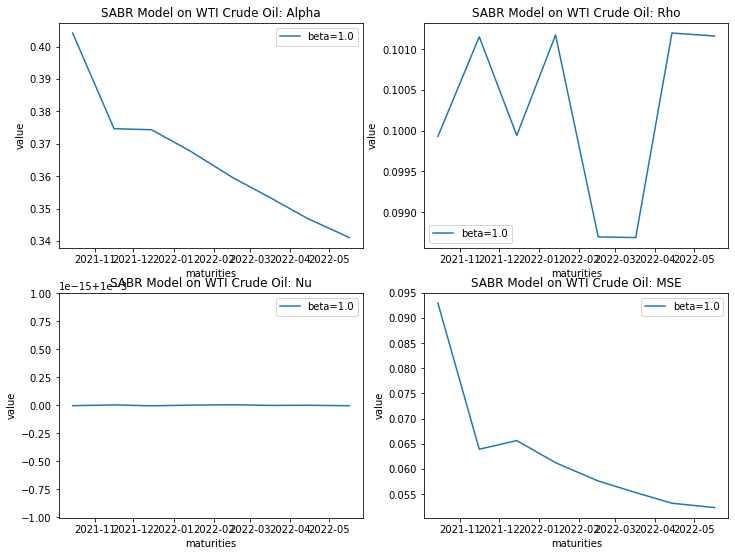

In [8]:
# SABR Volatility model

SABR_beta1 = SABRVolatilitySurface(beta=1, shift=0, label="SABR, beta=1, {}".format(data_label))
SABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, label="SABR, beta=.5 {}".format(data_label))
SABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, label="Normal SABR, beta=0, {}".format(data_label))
        
SABRComparison([SABR_beta1, SABR_beta5, SABR_beta0], title="SABR Model on {}".format(data_label))

C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


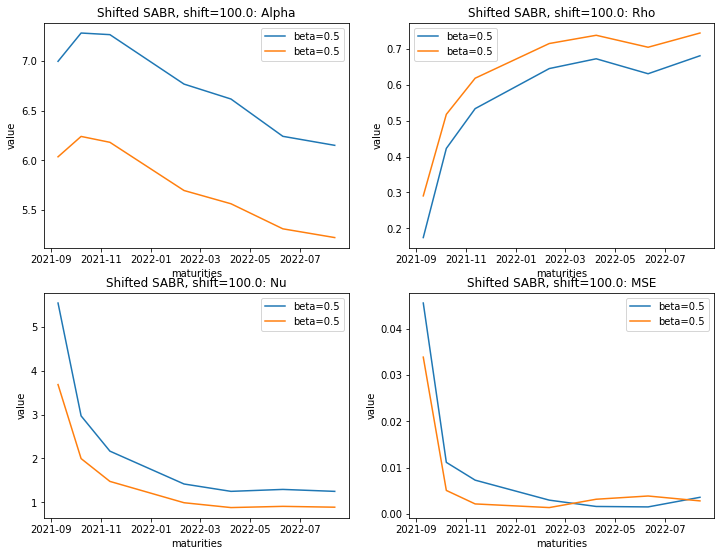

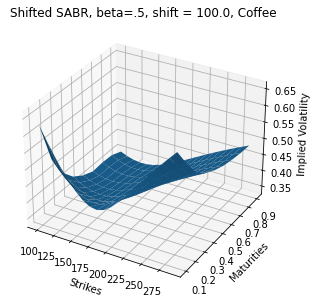

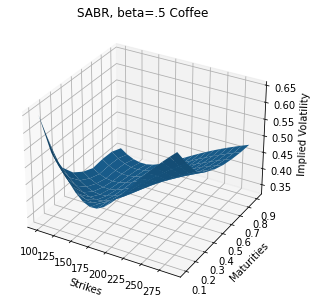

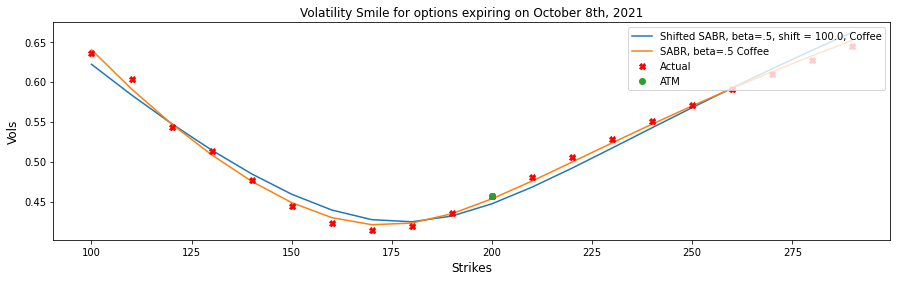

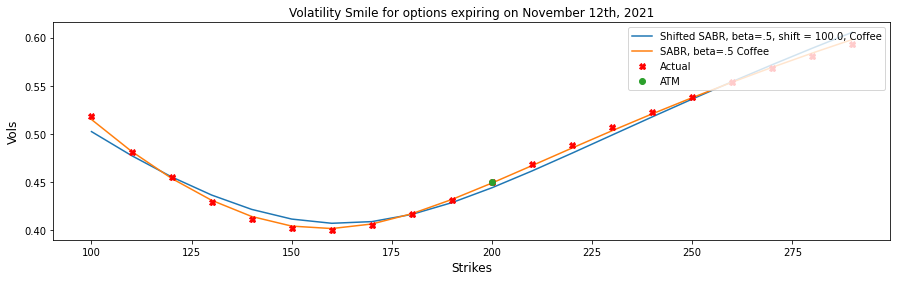

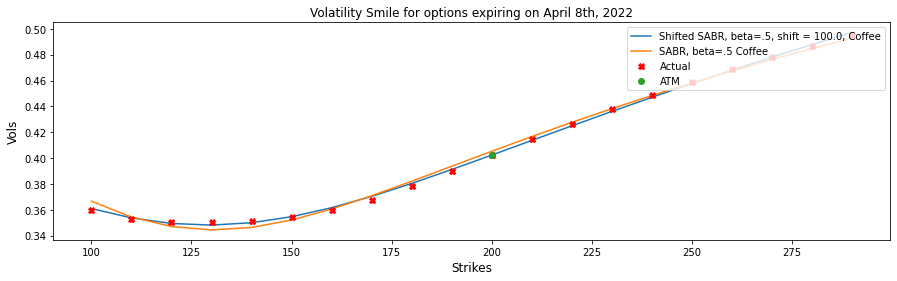

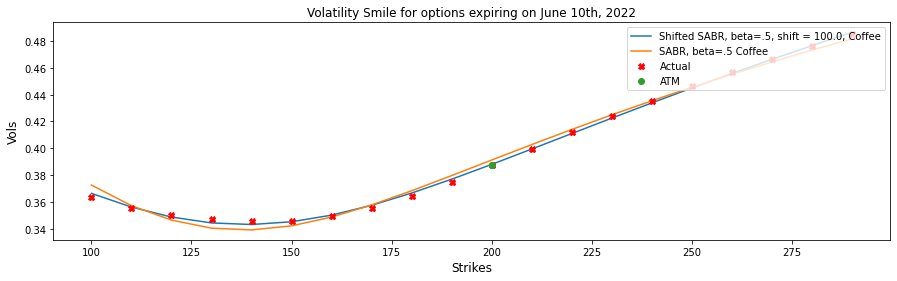

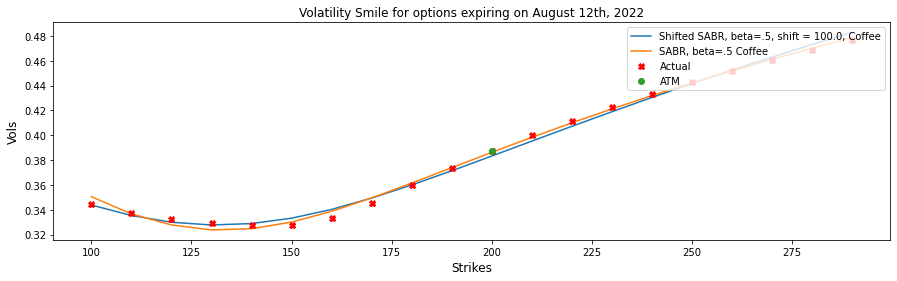

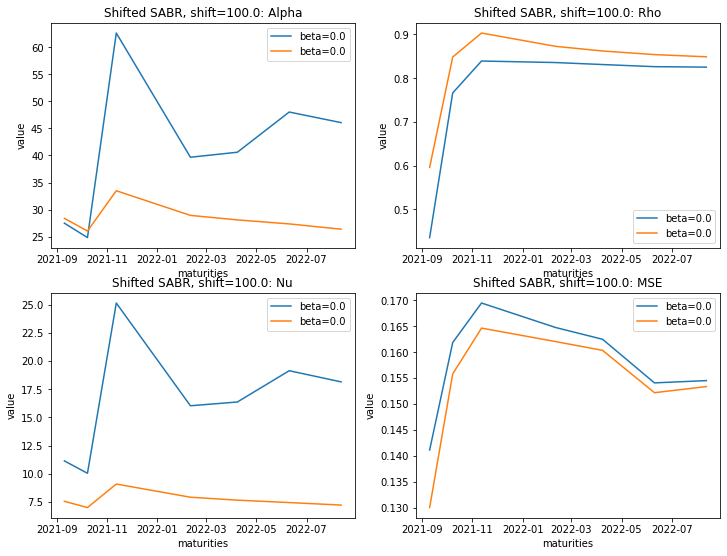

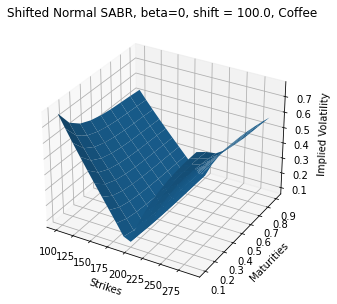

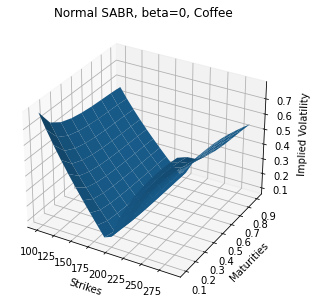

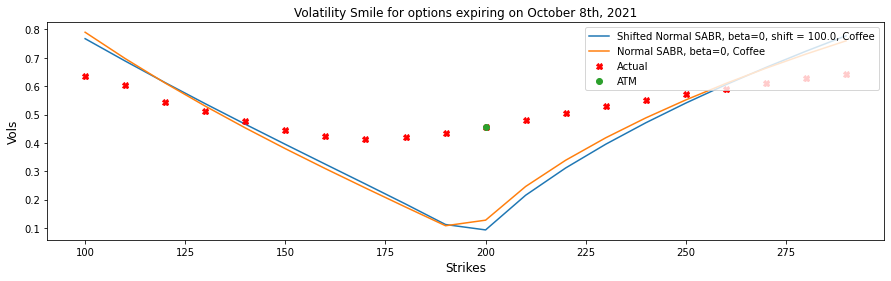

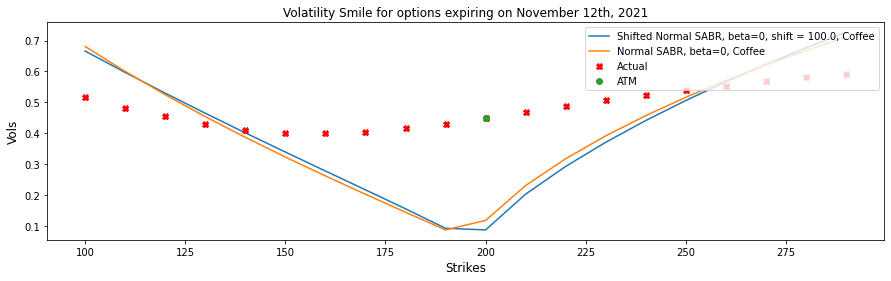

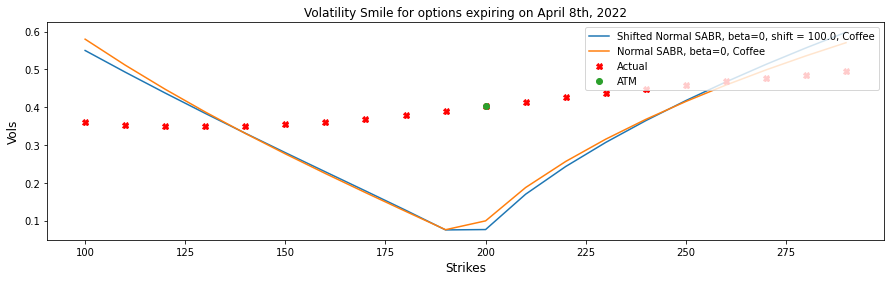

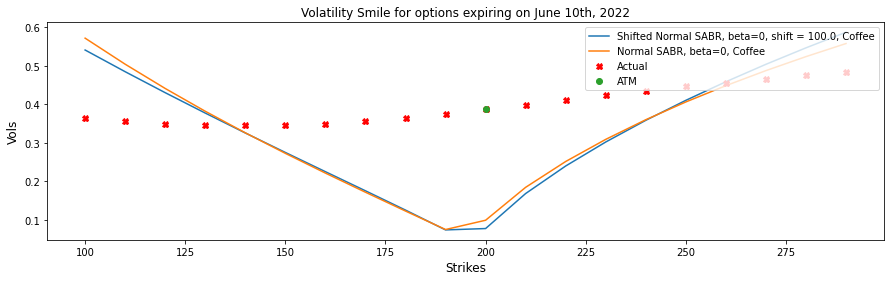

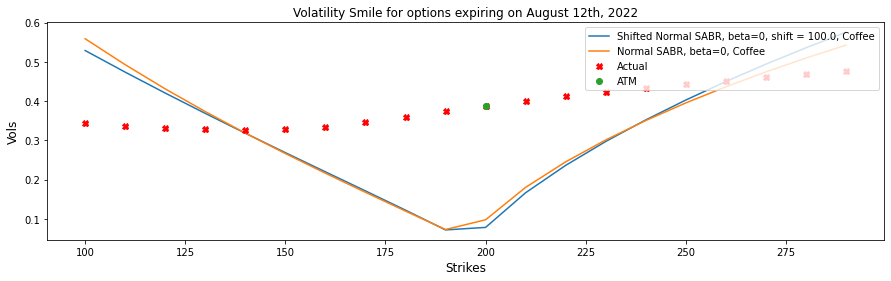

In [ ]:
# Shifted SABR Volatility model
shft = .50 * current_price
shiftedSABR_beta1 = SABRVolatilitySurface(beta=1, shift=shft, label="Shifted SABR, beta=1, shift = {}, {}".format(round(shft, 4), data_label))
shiftedSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=shft, label="Shifted SABR, beta=.5, shift = {}, {}".format(round(shft, 4), data_label))
shiftedSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=shft, label="Shifted Normal SABR, beta=0, shift = {}, {}".format(round(shft, 4), data_label))

SABRComparison([shiftedSABR_beta5, SABR_beta5], title="Shifted SABR, shift={}".format(round(shft, 4)))
SABRComparison([shiftedSABR_beta0, SABR_beta0], title="Shifted SABR, shift={}".format(round(shft, 4)))

C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


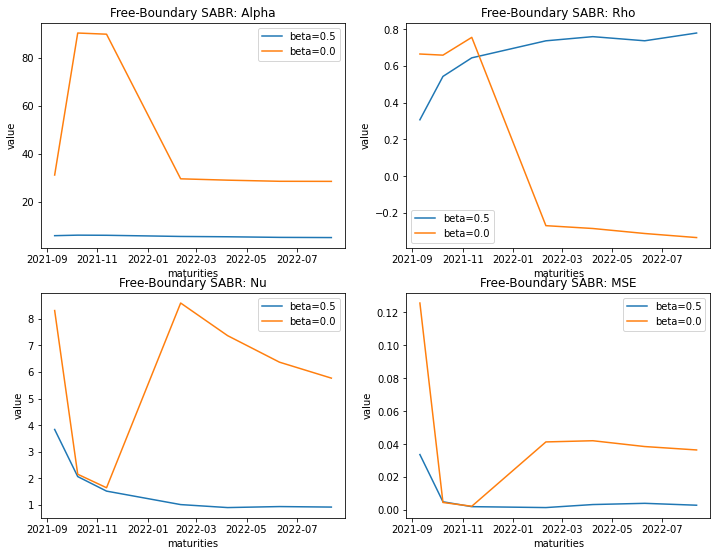

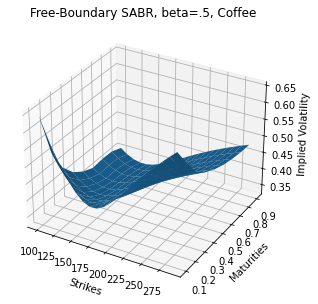

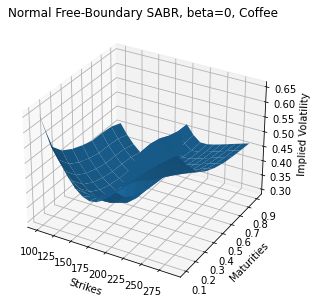

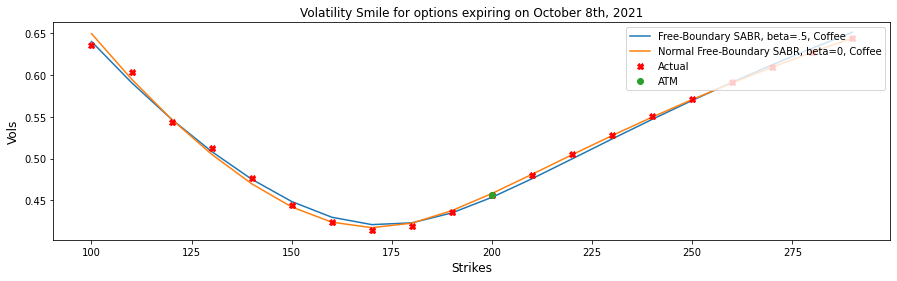

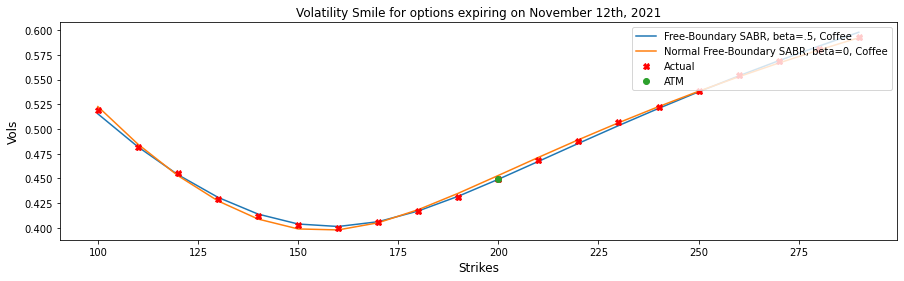

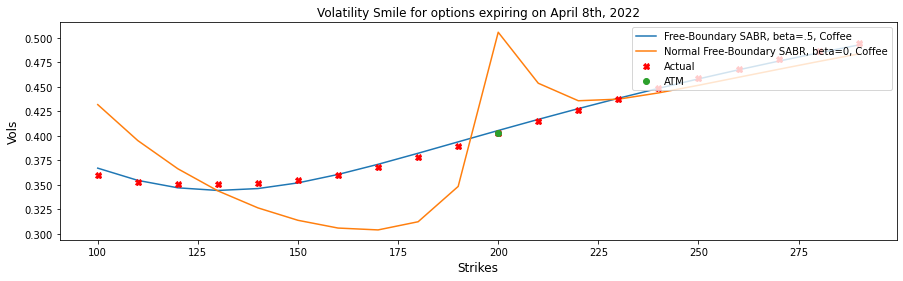

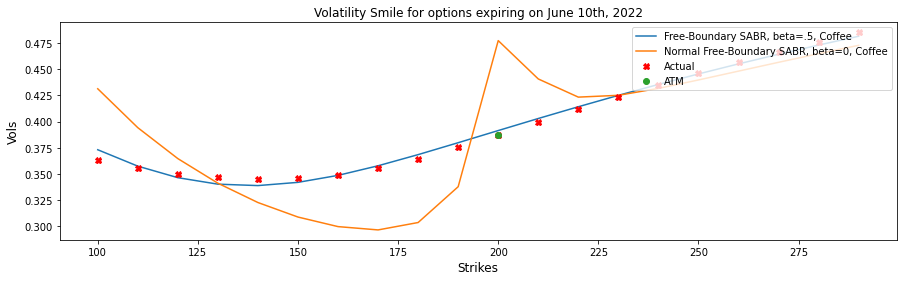

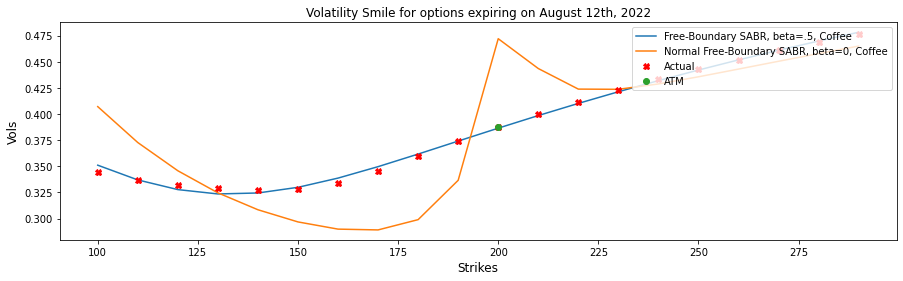

In [ ]:
# Free-Boundary SABR Volatility model

freeSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, method="floch-kennedy", label="Free-Boundary SABR, beta=.5, {}".format(data_label))
freeSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, method="floch-kennedy", label="Normal Free-Boundary SABR, beta=0, {}".format(data_label))

SABRComparison([freeSABR_beta5, freeSABR_beta0], title="Free-Boundary SABR")

alpha_free  beta_free   nu_free  rho_free   alpha_N  \
September 10th, 2021    6.025622        0.5  3.837102       0.0  6.025622   
October 8th, 2021       6.240184        0.5  2.063050       0.0  6.240184   
November 12th, 2021     6.185562        0.5  1.515953       0.0  6.185562   
February 10th, 2022     5.700999        0.5  1.008944       0.0  5.700999   
April 8th, 2022         5.567359        0.5  0.896325       0.0  5.567359   
June 10th, 2022         5.318200        0.5  0.933453       0.0  5.318200   
August 12th, 2022       5.442629        0.5  0.390795       0.0  5.442629   

                      beta_N      nu_N     rho_N       MSE  
September 10th, 2021     0.0  7.674203  0.244219  0.086771  
October 8th, 2021        0.0  4.126099  0.790108  0.031827  
November 12th, 2021      0.0  3.031906  0.990000  0.032229  
February 10th, 2022      0.0  2.017888  0.990000  0.085151  
April 8th, 2022          0.0  1.792650  0.990000  0.098923  
June 10th, 2022          0.0  1.866906  0.990000  0.093920  
August 12th, 2022        0.0  0.781591  0.990000  0.164709

No handles with labels found to put in legend.


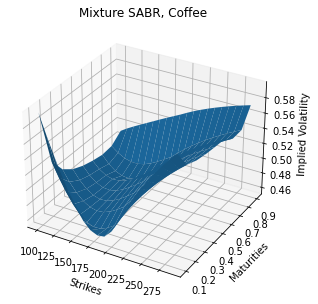

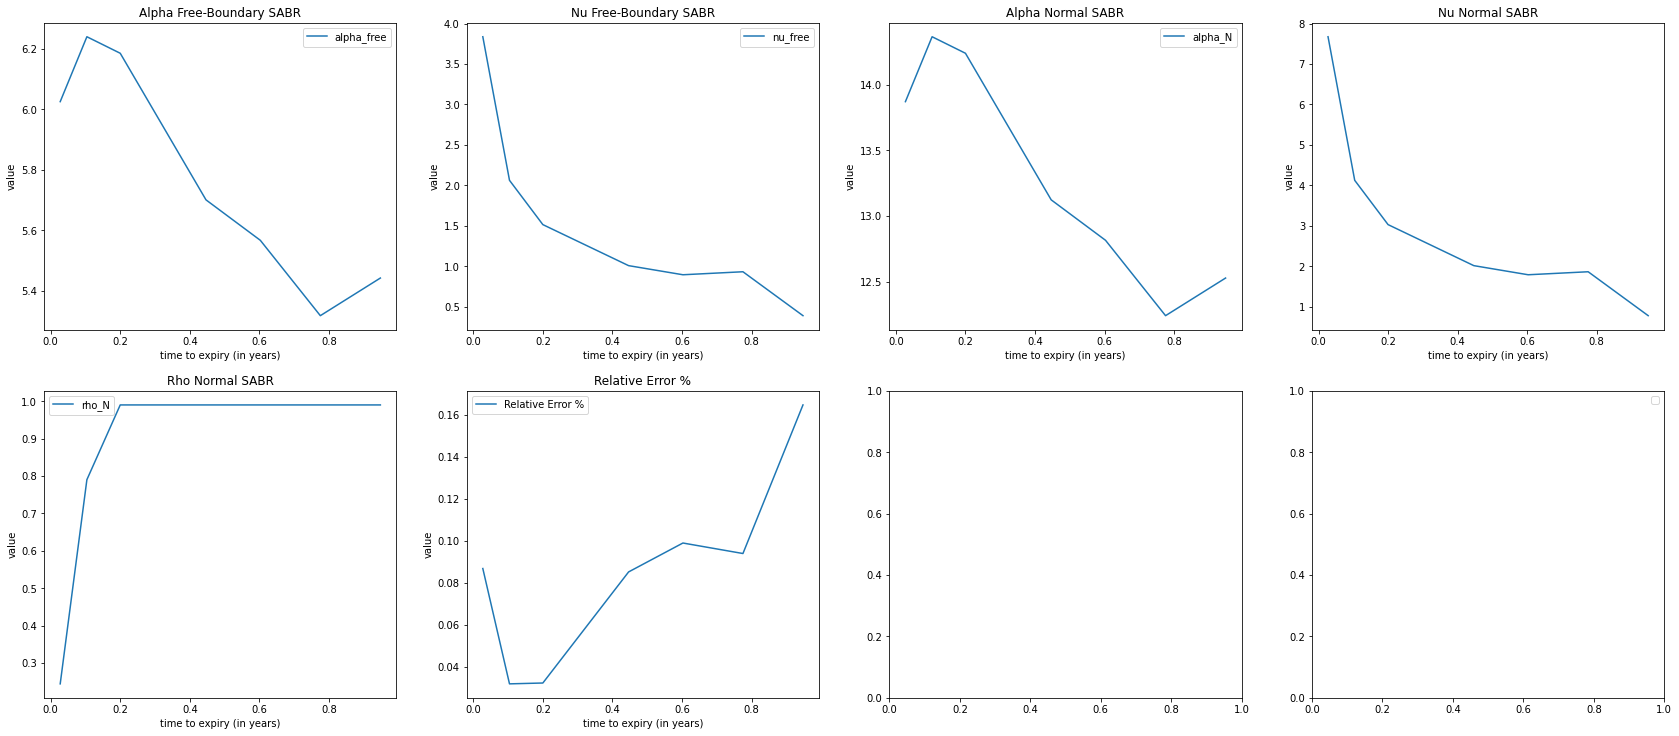

In [ ]:
# Mixed SABR 

tenors = dates[6:] if data == "SPX" else dates
mixtureSABR = MixtureSABRVolatilitySurface(dates=tenors) 
display(mixtureSABR.to_data())
plot_vol_surface([mixtureSABR.vol_surface], title=mixtureSABR.label)
mixtureSABR.plot()

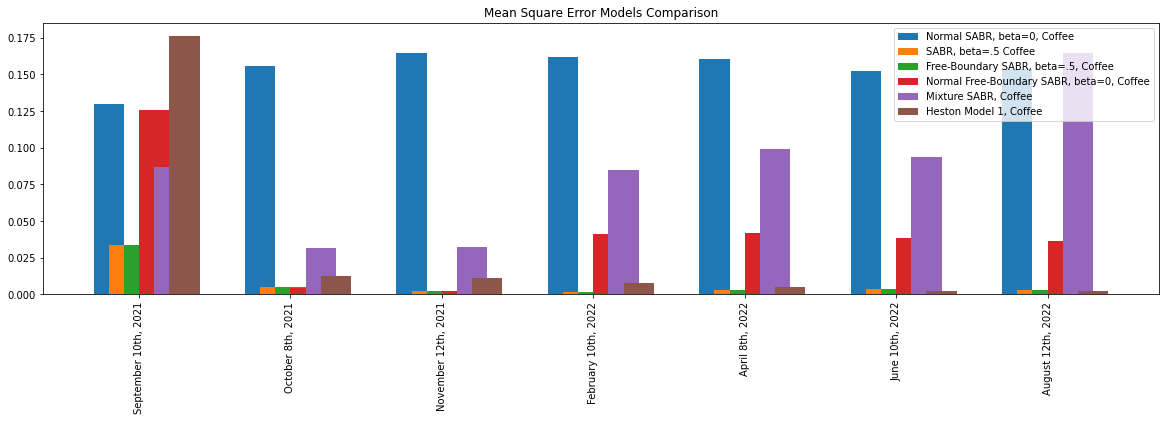

In [ ]:
# VOLATILITY SMILES ERRORS COMPARISON



# fix Mixture SABR errors due to missing dates
mixtureSABR_errors = None
if data == "SPX":
    np.concatenate((np.zeros(6), mixtureSABR.errors))
else:
     mixtureSABR_errors = mixtureSABR.errors

fig = plt.figure(figsize=(20, 5), )
width = .20
plt.bar(np.arange(len(maturities)) - 2*width/2, SABR_beta0.errors, label=SABR_beta0.label, width=width)
plt.bar(np.arange(len(maturities)) - width/2, SABR_beta5.errors, label=SABR_beta5.label, width=width)
plt.bar(np.arange(len(maturities)) , freeSABR_beta5.errors, label=freeSABR_beta5.label, width=width)
plt.bar(np.arange(len(maturities)) + width/2, freeSABR_beta0.errors, label=freeSABR_beta0.label, width=width)
plt.bar(np.arange(len(maturities)) + 2*width/2, mixtureSABR_errors, label=mixtureSABR.label, width=width)
plt.bar(np.arange(len(maturities)) + 3*width/2, hestonModel1.errors, label=hestonModel1.label, width=width)
plt.xticks(np.arange(len(maturities)), dates, rotation='vertical')
plt.title("Mean Square Error Models Comparison")
plt.legend()

Error
Normal SABR, beta=0, Coffee                0.154055
SABR, beta=.5 Coffee                       0.007454
Normal Free-Boundary SABR, beta=0, Coffee  0.041553
Free-Boundary SABR, beta=.5, Coffee        0.007456
Mixture SABR, Coffee                       0.084790

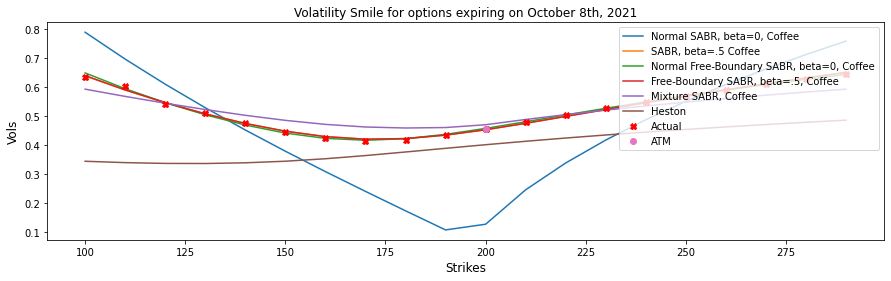

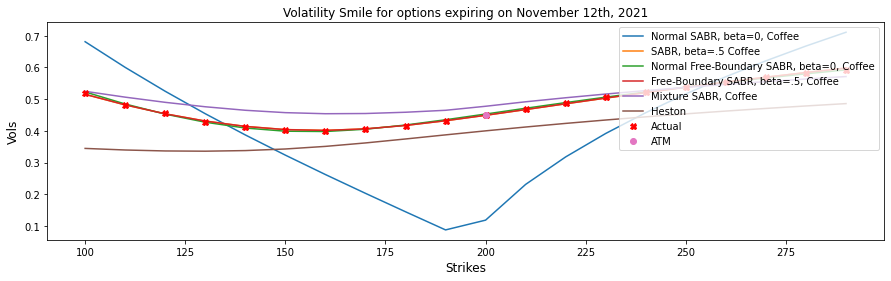

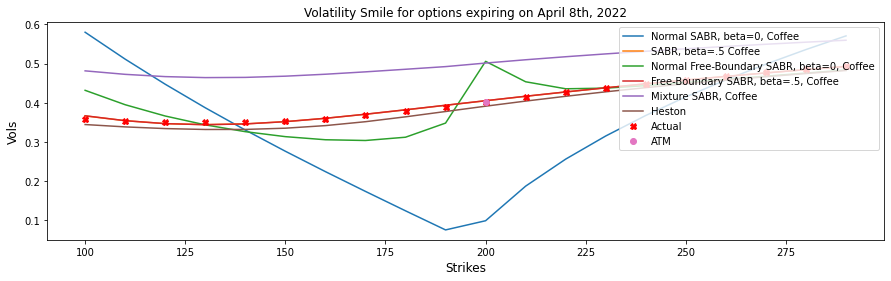

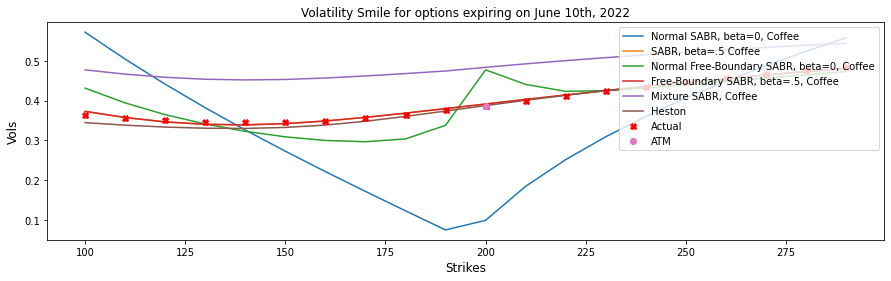

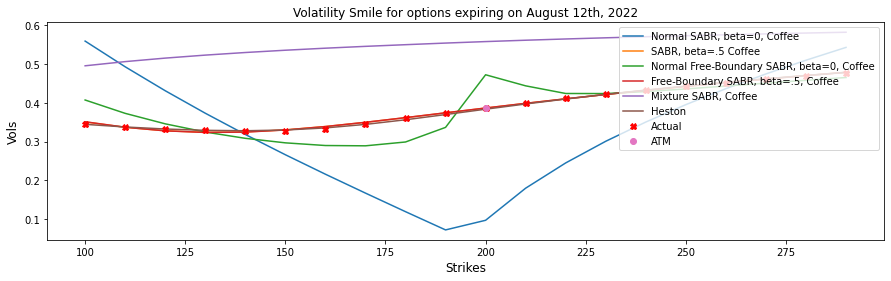

In [ ]:
# Volatility Smiles Comparisons (Final)

models = (
        SABR_beta0,
        SABR_beta5, 
        freeSABR_beta0, 
        freeSABR_beta5,
        mixtureSABR
        )

errors_data = pd.DataFrame([np.mean(m.errors) for m in models], index=[m.label for m in models], columns=["Error"])
display(errors_data)

smiles_comparison(models, heston_models=[hestonModel1])

Error
SABR, beta=1, Coffee                          0.027006
SABR, beta=.5 Coffee                          0.007454
Shifted SABR, beta=1, shift = 100.0, Coffee   0.028827
Shifted SABR, beta=.5, shift = 100.0, Coffee  0.010505
Normal Free-Boundary SABR, beta=0, Coffee     0.041553
Free-Boundary SABR, beta=.5, Coffee           0.007456

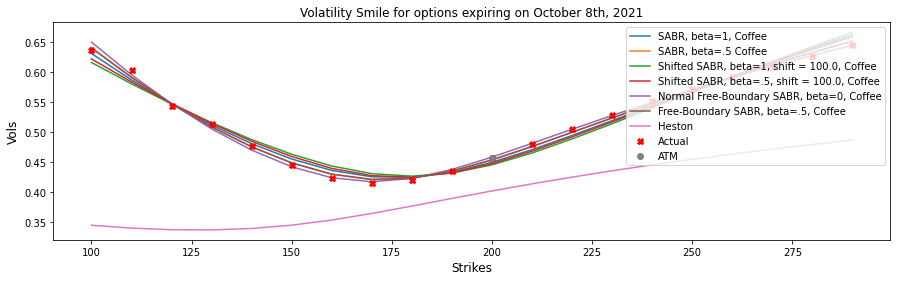

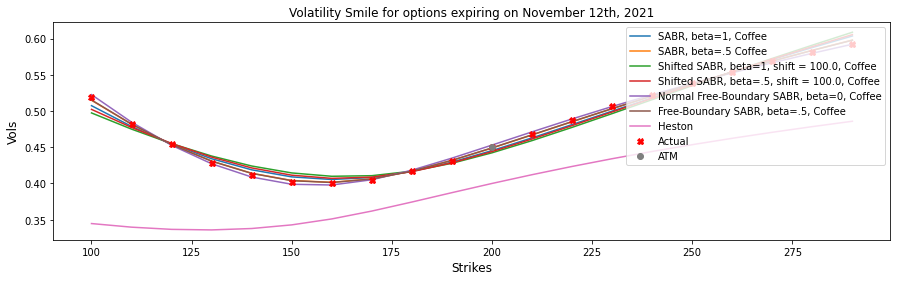

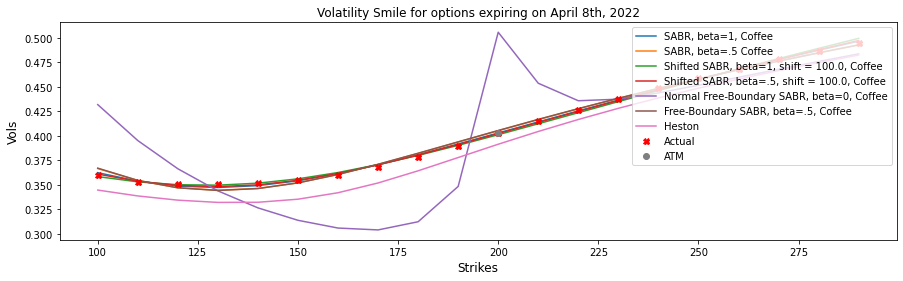

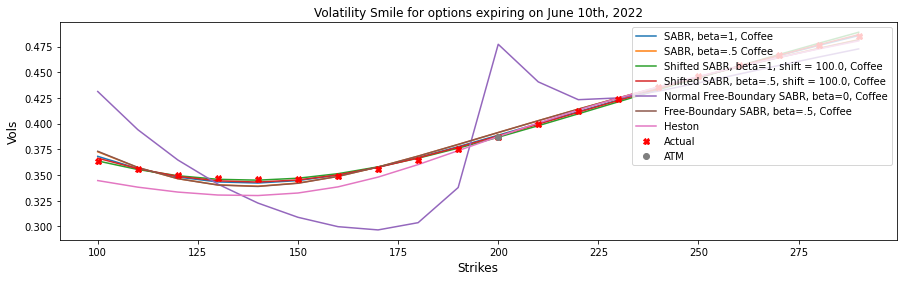

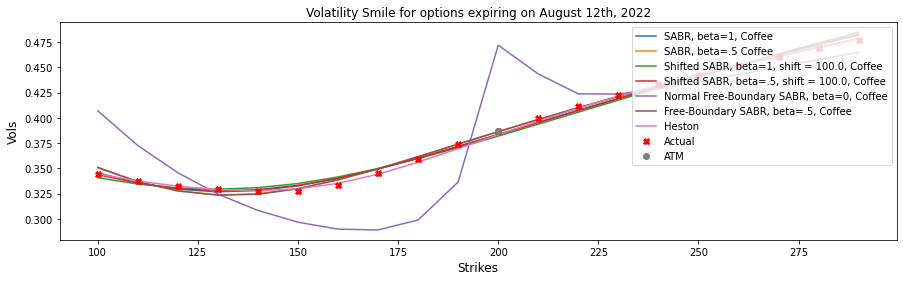

In [ ]:
# Volatility Smiles Comparisons 2 (Final)

models = (
        SABR_beta1,
        SABR_beta5, 
        shiftedSABR_beta1,
        shiftedSABR_beta5,
        freeSABR_beta0, 
        freeSABR_beta5,
        )

errors_data = pd.DataFrame([np.mean(m.errors) for m in models], index=[m.label for m in models], columns=["Error"])
display(errors_data)

smiles_comparison(models, heston_models=[hestonModel1])

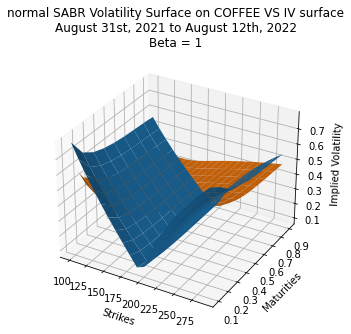

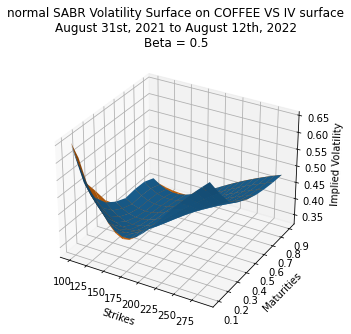

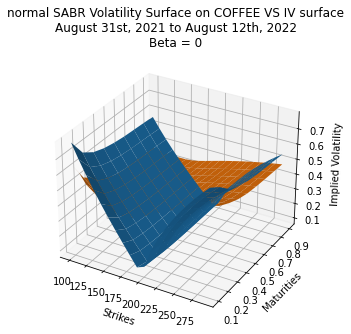

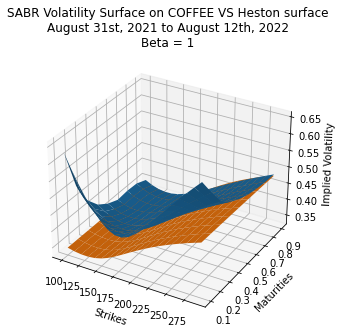

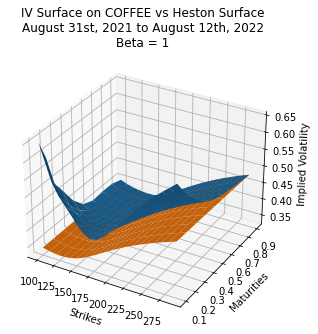

In [ ]:
# Volatility Surfaces plots comparison

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0.5".format(data, today, dates[-1])
plot_vol_surface([SABR_beta5.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0".format(data, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "SABR Volatility Surface on {} VS Heston surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([SABR_beta1.vol_surface, hestonModel1.heston_vol_surface], title=title)

title = "IV Surface on {} vs Heston Surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([black_var_surface, hestonModel1.heston_vol_surface], title=title)

(None, None, None)

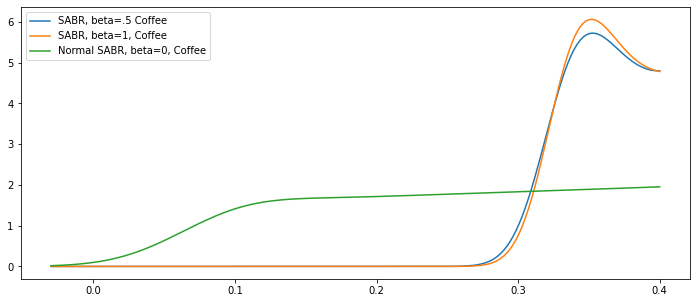

In [ ]:
from scipy.stats import gaussian_kde
import seaborn as sns
plt.figure(figsize=plot_size)
def density(model):
    rn = []
    for i in np.arange(0, 1.5, .01):
        for j in np.arange(model.vol_surface.minStrike(), model.vol_surface.maxStrike(), 5):
            rn.append(model.vol_surface.blackVol(i,j))

    density = gaussian_kde(rn)
    xs = np.linspace(-.03,.4,200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs), label=model.label)
    
    plt.legend()



density(SABR_beta5), density(SABR_beta1), density(SABR_beta0), 

C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\R

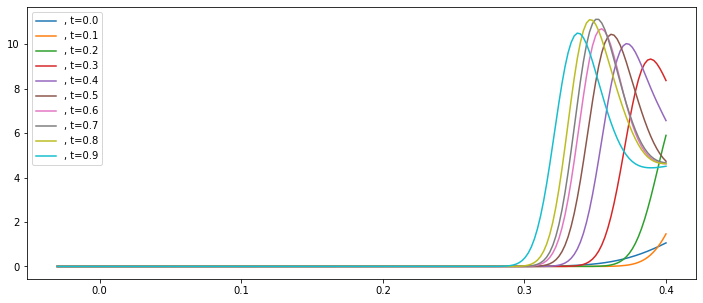

C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\R

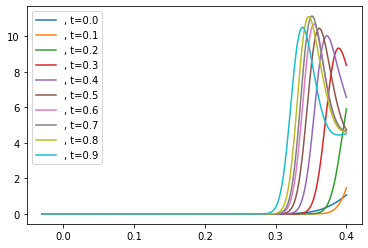

In [ ]:
from scipy.stats import gaussian_kde

plt.figure(figsize=plot_size)
def density(model, t):
    rn = []

    for j in np.arange(model.vol_surface.minStrike(), model.vol_surface.maxStrike(), 5):
        rn.append(model.vol_surface.blackVol(t,j))

    density = gaussian_kde(rn)
    xs = np.linspace(-.03,.4,200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs), label=model.label+", t="+str(round(t, 2)))
    
    plt.legend()


for i in np.arange(0,1,.1):
    density(SABRVolatilitySurface(beta=.5, zero_rho=True), i)
plt.show()
for i in np.arange(0,1,.1):
    density(SABRVolatilitySurface(beta=.5, zero_rho=False), i)
